In [10]:
import json
import os

pathways = {}

for file in os.listdir("pathways"):
    if '.json' in file:
        pathways[file.replace(".json", "")] = json.load(open(os.path.join("pathways", file)))['geneSymbols']

EPCAMPathway = 'EPCAM in Cancer Cell Motility and Proliferation'
WNTPathway = 'WNT in Epithelial to Mesenchymal Transition in Cancer'

pathways[EPCAMPathway] = "CSNK1A1	CSNK2A1	KREMEN1	AXIN1	DKK1	DKK2	POU5F1	BACE1	CLDN7	ADAM17	APC	CD9	CCNE1	NANOG	CD44	LEF1	GSK3B	CTNNB1	FHL2	LRP6	TNC	TACSTD2	LRP5	PSEN2	CLDN1	EPCAM	SOX2	BSG	CCND1	DVL1	CDH1	TSPAN8	DVL2	MYC	DVL3	CTNNA1".split("\t")
pathways[WNTPathway] = "CSNK1A1	MPP5	CSNK2A1	MMP2	FN1	KRT8	AXIN1	MMP9	CLDN7	ZEB1	TJP1	OCLN	ACTA2	MMP15	ZEB2	KRT19	APC	AXL	KRT18	VIM	SNAI2	SNAI1	S100A4	TCF4	LEF1	CRB3	FOXC2	GSK3B	FOXC1	PATJ	SERPINE1	CTNNB1	LRP6	TNC	LRP5	TWIST1	CLDN1	CDH2	DVL1	CDH1	DVL2	GSC	DVL3".split("\t")

In [5]:
genes = open("training_results_v2/v2_repr_contrastive/genes.txt").read().split("\n")

In [39]:
pathways['All Genes'] = genes

In [12]:
from collections import defaultdict

# Eventually should be MAE
CV_results = defaultdict(lambda: {"AUROC": [], "Spearman": []})

for file in sorted(os.listdir("training_results_v2/v2_repr_contrastive/")):
    if ".json" not in  file:
        continue
    
    ident = file.split("_heldout")[0]

    stats = json.load(open(os.path.join("training_results_v2/v2_repr_contrastive/", file)))

    CV_results[ident]['AUROC'].append(stats['stats']['auroc_values'])
    CV_results[ident]['Spearman'].append(stats['stats']['spearman_values'])

# Add Inception results
for file in sorted(os.listdir("training_results_v2/v6_cnn_models_augmented_2_epochs/")):
    if ".json" not in  file:
        continue
    
    ident = 'Inception'

    stats = json.load(open(os.path.join("training_results_v2/v6_cnn_models_augmented_2_epochs/", file)))

    CV_results[ident]['AUROC'].append(stats['stats']['auroc_values'])
    CV_results[ident]['Spearman'].append(stats['stats']['spearman_values'])

# Flatten CV results

import numpy as np

CV_results_flat = {}

for key in CV_results:
    CV_results_flat[key] = {
        key_2: np.array(CV_results[key][key_2]).mean(axis=0) for key_2 in CV_results[key]
    }

CV_results_flat['Best CGNN For Gene'] = {
    metric_name: np.array([CV_results_flat[ident][metric_name] for ident in CV_results.keys() if ident != 'Inception']).max(axis=0) for metric_name in CV_results[key]
}

CV_results_flat['Best Overall For Gene'] = {
    metric_name: np.array([CV_results_flat[ident][metric_name] for ident in CV_results.keys()]).max(axis=0) for metric_name in CV_results[key]
}

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def humanize_pathway_name(string: str):
    string = string.replace("HALLMARK_", "")

    return string.replace("_", " ").title()

def humanize_technique_string(name: str):
    if name == 'Inception':
        return 'Inception V3'
    if name == 'Best CGNN For Gene':
        return name
    if name == 'Best Overall For Gene':
        return name
    
    pretrained = 'repr' in name
    cell_reg = 'cellreg' in name
    if pretrained and cell_reg:
        return 'Pretrained + Cell Reg'
    elif pretrained:
        return 'Pretrained'
    elif cell_reg:
        return 'Cell Reg'
    else:
        return 'Vanilla'

def create_pathway_score_dict(CV_results_flat, pathways, key):
    results = {}
    for technique, gene_score_dict in CV_results_flat.items():
        gene_scores = gene_score_dict[key]
        for pathway, pathway_genes in pathways.items():
            # Select genes which are in the data
            pathway_genes = [gene for gene in pathway_genes if gene in genes]
            unavailable_genes = [gene for gene in pathway_genes if gene not in genes]
            if len(unavailable_genes) > 0:
                print("WARNING: Unavailable genes for technique", technique, "and pathway", pathway, ":", unavailable_genes)
            pathway_scores = [gene_scores[genes.index(gene)] for gene in pathway_genes]

            results[technique, pathway] = pathway_scores

    return results


In [48]:
def plot_pathway_score_dict(pathway_score_dict):
    sns.set_style("whitegrid")

    # Prepare the data for boxplot
    techniques = []
    pathway_names = []
    data = []
    labels = []

    unique_pathways = set()

    for (technique, pathway), pathway_scores in pathway_score_dict.items():
        print(pathway, technique, np.median(pathway_scores))
        for scores in pathway_scores:
            techniques.append(humanize_technique_string(technique))
            pathway_names.append(pathway)
            data.append(scores)
            unique_pathways.add(pathway)

    df = pd.DataFrame({
        'technique': techniques,
        'pathway': pathway_names,
        'scores': data
    })

    # Create the boxplot
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    sns.boxenplot(data=df, x='pathway', y='scores', hue='technique', order=list(unique_pathways))
    labels = [humanize_pathway_name(pathway_name) for pathway_name in list(unique_pathways)]
    plt.xticks(range(len(labels)), labels, rotation=15, ha='right', fontsize=10)
    plt.xlabel('Pathway')
    plt.title('Comparison of Modeling Techniques for Different Pathways')

    # plt.figure(figsize=(6, 5))
    # labels = ['Best Overall For Gene', 'Inception V3', 'Best CGNN For Gene', 'Pretrained + Cell Reg', 'Pretrained', 'Cell Reg', 'Vanilla']
    # sns.boxenplot(data=df, x='technique', y='scores', order=labels)
    # labels = sorted(set(techniques))
    # plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
    # plt.xlabel('Technique')
    # plt.title('Comparison of Modeling Techniques')

    plt.ylabel('AUROC Score')
    plt.tight_layout()
    plt.show()

In [44]:
plt.rcParams['figure.figsize']

[6.4, 4.8]

HALLMARK_ALL_GENES cellmodel_prior-none_cellreg-enabled 0.8012361906510763
HALLMARK_ALL_GENES cellmodel_prior-none 0.8092509515319865
HALLMARK_ALL_GENES cellmodel_prior-repr_cellreg-enabled 0.8048547752192444
HALLMARK_ALL_GENES cellmodel_prior-repr 0.8094282740376522
HALLMARK_ALL_GENES Inception 0.8203956908455113
HALLMARK_ALL_GENES Best CGNN For Gene 0.8150835654950264
HALLMARK_ALL_GENES Best Overall For Gene 0.8206291274046313


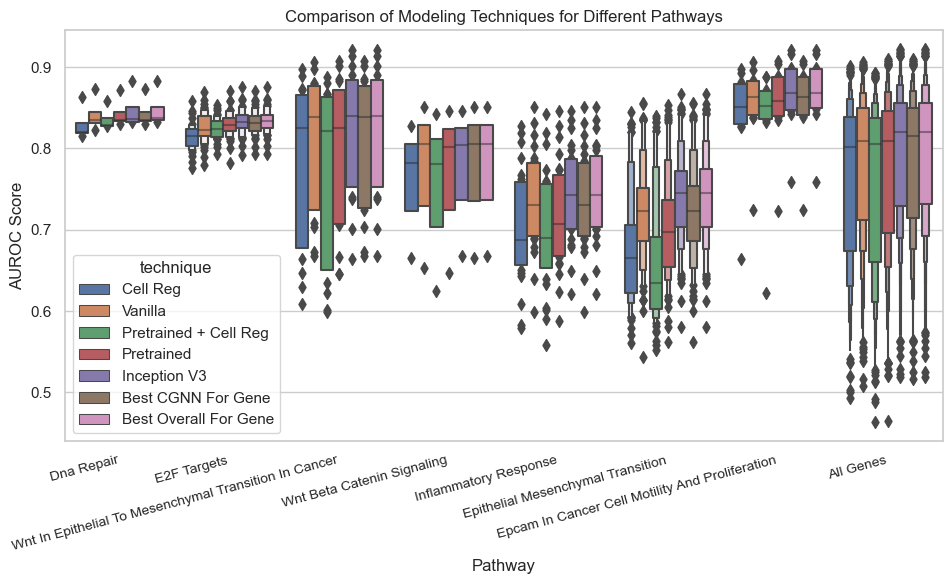

In [51]:
plot_key = 'AUROC'
selected_pathways = [
    # "HALLMARK_ANGIOGENESIS",
    "HALLMARK_DNA_REPAIR",
    "HALLMARK_E2F_TARGETS",
    "HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION",
    "HALLMARK_INFLAMMATORY_RESPONSE",
    # "HALLMARK_TGF_BETA_SIGNALING",
    "HALLMARK_WNT_BETA_CATENIN_SIGNALING",
    EPCAMPathway,
    WNTPathway,
    "All Genes",
]
pathways_ = {k: pathways[k] for k in selected_pathways}
# pathways_ = {'HALLMARK_ALL_GENES': pathways['HALLMARK_ALL_GENES']}
plot_pathway_score_dict(create_pathway_score_dict(CV_results_flat, pathways_, plot_key))

In [33]:
techniques = []
pathway_names = []
scores = []

# This one does all pathways
for (technique, pathway_name), scores_ in create_pathway_score_dict(CV_results_flat, pathways, plot_key).items():
    techniques.append(humanize_technique_string(technique))
    pathway_names.append(humanize_pathway_name(pathway_name))
    scores.append(np.median(scores_))

df = pd.DataFrame({
    'Technique': techniques,
    'Pathway': pathway_names,
    'AUROC': scores
})

df.head()

df.to_csv("performance_by_pathway.csv")

In [34]:
# Get best performing technique per pathway

# Filter out "Best Overall" and "Best CGNN"
df2 = df.loc[df['Technique'] != 'Best Overall For Gene', :].loc[df['Technique'] != 'Best CGNN For Gene', :].loc[df['Technique'] != 'Inception V3', :]

best_technique_df = df2.loc[df2.groupby('Pathway')['AUROC'].idxmax(), ['Technique', 'Pathway']]
best_technique_df

,Technique,Pathway
149,Pretrained + Cell Reg,Adipogenesis
203,Pretrained,All Genes
66,Vanilla,Allograft Rejection
99,Vanilla,Androgen Response
89,Vanilla,Angiogenesis
82,Vanilla,Apical Junction
73,Vanilla,Apical Surface
85,Vanilla,Apoptosis
76,Vanilla,Bile Acid Metabolism
79,Vanilla,Cholesterol Homeostasis


In [35]:
def bootstrap(values):
    values = values[~np.isnan(values)]
    np.random.seed(42)
    performances_bootstrapped=[np.quantile(np.random.choice(values,len(values),replace=True),0.5) for i in range(1000)]
    med = np.quantile(values,0.5)
    p975 = np.quantile(performances_bootstrapped,[0.025,0.975])
    width = (p975[1]-p975[0])/2
    return {"median": med, "width": width, "formatted": f"{med:.4f} ± {width:.4f}"}

In [36]:
bootstrap(CV_results_flat['Best Overall For Gene']['AUROC'])

{'median': 0.8206291274046313,
 'width': 0.0076219649745359885,
 'formatted': '0.8206 ± 0.0076'}

In [37]:
bootstrap(CV_results_flat['Best Overall For Gene']['Spearman'])

{'median': 0.5765715980256065,
 'width': 0.012246668192159083,
 'formatted': '0.5766 ± 0.0122'}

<Axes: title={'center': 'Comparison of AUROC scores'}, xlabel='Inception V3', ylabel='Best CGNN For Gene'>

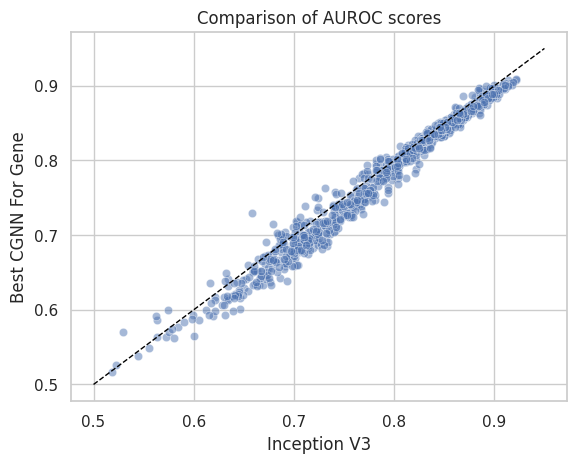

In [27]:
# Scattering cells models + etc.

auroc1 = CV_results_flat['Inception']['AUROC']
auroc2 = CV_results_flat['Best CGNN For Gene']['AUROC']

sns.scatterplot(x=auroc1, y=auroc2, alpha=0.5)
plt.xlabel("Inception V3")
plt.ylabel("Best CGNN For Gene")

min_gap = 0.04

bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
# texts = []

# for i in range(len(genes)):
#     if abs(auroc1[i] - auroc2[i]) >= min_gap:
#         texts.append(plt.text(auroc1[i], auroc2[i], genes[i], fontsize=8, bbox=bbox_props))

# import adjustText

# adjustText.adjust_text(texts)

plt.title("Comparison of AUROC scores")
sns.lineplot(x=[0.5, 0.95], y=[0.5, 0.95], color='black', linewidth=1, linestyle='--')
